In [1]:
torch.setdefaulttensortype('torch.FloatTensor')
require 'cutorch'

exact = true
separateParams = false

### Load Cityscapes dataset

In [2]:
package.loaded.cityscapes = nil
cityscapes = require 'cityscapes'

cityscapes.relative = '/home/shrubb/Datasets/Cityscapes/'
nClasses = cityscapes.nClasses -- 19

trainFiles = cityscapes.loadNames('train')
valFiles = cityscapes.loadNames('val')

Loading images from /home/shrubb/Datasets/Cityscapes/leftImg8bit/train/. Example cities: hanover, zurich	


Loading images from /home/shrubb/Datasets/Cityscapes/leftImg8bit/val/. Example cities: ., munster	


In [3]:
modelName = '077-resnet50-8x-PSP'
cityscapes.dsize = {1024, 512}

### Render labels for displaying

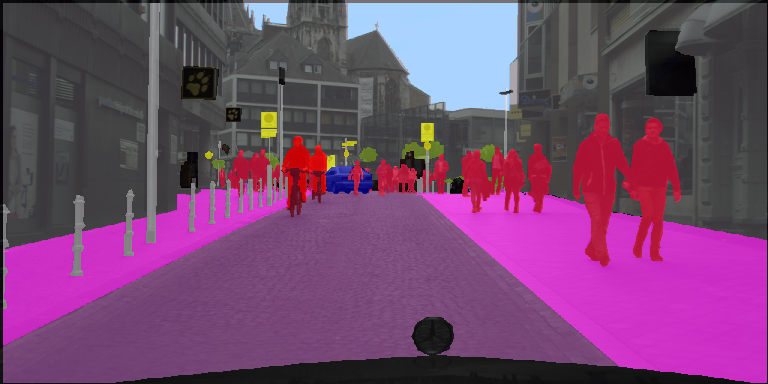

In [4]:
-- example blending
local k = 19
local img, labels = cityscapes.loadSample(trainFiles[k])
itorch.image(cityscapes.renderLabels(labels, img))

In [5]:
intKind = 'IntegralSmartNorm'
_G[intKind] = nil
debug.getregistry()[intKind] = nil 
package.loaded[intKind] = nil

require(intKind)

In [5]:
local modelName = modelName
net, GSconfig = 
    assert(loadfile('Models/' .. modelName .. '.lua'))(cityscapes.dsize[1], cityscapes.dsize[2], nClasses)

ints = net:findModules(intKind)
for i = 1,#ints do
    ints[i].normalize = true
    ints[i].exact = exact
    ints[i].saveMemoryIntegral = false
end
print('Number of IntegralSmartNorm modules: ' .. #ints)
print('Number of group sparsity regularized modules: ' .. #GSconfig)

require 'cunn'
net:cuda()
collectgarbage()

Number of IntegralSmartNorm modules: 0	
Number of group sparsity regularized modules: 0	


In [6]:
math.randomseed(666)
torch.manualSeed(666)
if CUDA then cutorch.manualSeed(666) end

net:reset()

if separateParams then
    params, gradParams = net:parameters()
else
    params, gradParams = net:getParameters()
end

optnet = require 'optnet'
optimized = false

In [7]:
require 'optim'

datasetIdx = 1

if separateParams then
    optimStates = {}

    local intParamsCount = 0

    for i = 1,#params do
        optimStates[i] = {
            learningRate = 1e-3,
            momentum = 0.9,
            nesterov = true,
            dampening = 0,
            learningRateDecay = 0,
            weightDecay = 2e-4
        }

        for k = 1,#ints do
            if 
                params[i] == ints[k].xMin or
                params[i] == ints[k].xMax or
                params[i] == ints[k].yMin or
                params[i] == ints[k].yMax then

                ints[k].params = ints[k].params or {}
                table.insert(ints[k].params, i)

                optimStates[i].weightDecay = 2e-4 -- 0.0185
                optimStates[i].learningRate = optimStates[i].learningRate
                intParamsCount = intParamsCount + 1
                break
            end
        end

        for k = 1,#GSconfig do
            assert(torch.type(GSconfig[k].haarConv):find('Convolution'))
            assert(torch.type(GSconfig[k].int):find('Integral'))
            assert(torch.type(GSconfig[k].bn):find('SpatialBatchNorm'))

            GSconfig[k].bnMedGamma = 1
            GSconfig[k].bnMedBeta = 0

            if params[i] == GSconfig[k].haarConv.weight then
                optimStates[i].GSconfigIdx = k
    --             optimStates[i].haarConv = haarConvs[k]
    --             optimStates[i].int = assert(ints[k])
    --             optimStates[i].bn = assert(optimStates[i].haarConv.bn)

                -- let us add WD manually
                optimStates[i].weightDecayL2 = optimStates[i].weightDecay
                -- don't let `optim` optimizer do it
                optimStates[i].weightDecay = 0

                optimStates[i].weightDecayGS = 1e-3 -- need to tune
                optimStates[i].groupSparsityTensor = params[i]:clone()
                optimStates[i].tmpSumTensor = params[i].new(params[i]:size(1), 1, 1, 1)
            elseif params[i] == GSconfig[k].bn.weight or params[i] == GSconfig[k].bn.bias then
                GSconfig[k].bn.params = GSconfig[k].bn.params or {}
                table.insert(GSconfig[k].bn.params, i)
            end
        end
    end

    print('Number of IntegralSmartNorm parameter tensors: ' .. intParamsCount)
else
    optimStates = {
        learningRate = 1e-3,
        momentum = 0.9,
        nesterov = true,
        dampening = 0,
        learningRateDecay = 0,
        weightDecay = 2e-4
    }
end

In [5]:
outputDir = 'Cityscapes segmentation/' .. modelName .. '/001/'
os.execute('mkdir "' .. outputDir .. 'Images/train" -p')
os.execute('mkdir "' .. outputDir .. 'Images/val" -p')

In [10]:
-- do return end

for k = 1,#ints do
    for p = 1,ints[k].xMin:nElement() do
        ints[k]:resetSingleWindow(p)
    end
    ints[k].xMin:mul(1.5)
    ints[k].xMax:mul(1.5)
    ints[k].yMin:mul(1.5)
    ints[k].yMax:mul(1.5)
end

In [7]:
package.loaded.WindowDebugger = nil
debug.getregistry().WindowDebugger = nil
WindowDebugger = nil

require 'WindowDebugger'

-- ints = {1,1,1,1,1,1}
wDebs = (#ints > 0) and {} or nil
for k = 1,#ints do wDebs[k] = WindowDebugger() end

In [8]:
-- Load a saved model
do return end
require 'nngraph'
require 'cunn'
require 'cudnn'

net, optimStates, GSconfig = table.unpack(torch.load(outputDir .. 'net.t7'))
ints = net:findModules(intKind)
for i = 1,#ints do
    ints[i].normalize = true
    ints[i].exact = exact
end

if separateParams then
    params, gradParams = net:parameters()
else
    params, gradParams = net:getParameters()
end

require 'optim'

loaded = true

datasetIdx = 1

In [9]:
require 'optim'

onlineLossLogger = optim.Logger(outputDir .. 'onlineLossLog.log')
evalLogger = optim.Logger(outputDir .. 'evalLog.log')
evalAccLogger = optim.Logger(outputDir .. 'evalAccLog.log')

onlineLossLogger:setNames{'Online batch loss'}
evalLogger:setNames{'Train loss', 'Validation loss'}
evalAccLogger:setNames{
    'Train IoU class', 'Train IoU category',
    'Validation IoU class', 'Validation IoU category'}

onlineLossLogger:style{'-'}
evalLogger:style{'-', '-'}
evalAccLogger:style{'-', '-', '-', '-'}

onlineLossLogger.showPlot = false
evalLogger.showPlot = false
evalAccLogger.showPlot = false

haarConvLoggers = {}
for k = 1,#GSconfig do
    haarConvLoggers[k] = optim.Logger(outputDir .. 'haarConv' .. k .. 'Log.log')
    local names, styles = {}, {}
    for i = GSconfig[k].l,GSconfig[k].r do
        table.insert(names, tostring(i))
        table.insert(styles, '-')
    end
    haarConvLoggers[k]:setNames(names)
    haarConvLoggers[k]:style(styles)
    haarConvLoggers[k].plotRawCmd = 'unset key'
    haarConvLoggers[k].showPlot = false
end

haarConvZeroCountLogger = optim.Logger(outputDir .. 'haarConvZeroCountLog.log')
local names, styles = {}, {}
for k = 1,#GSconfig do
    table.insert(names, tostring(k))
    table.insert(styles, '-')
end
haarConvZeroCountLogger:setNames(names)
haarConvZeroCountLogger:style(styles)
haarConvZeroCountLogger.showPlot = false

function needToPlot(_onlineLossLogger)
    local plotFreq = 10
    local count = #_onlineLossLogger.symbols[1] + 1
    while count > 1000 do
        plotFreq = plotFreq * 10
        count = count / 10
    end
    
    return #_onlineLossLogger.symbols[1] % plotFreq == 0
end

In [10]:
for k = 1,#ints do
    if wDebs and loaded and paths.filep(outputDir .. 'wd' .. k .. '.t7') then
        wDebs[k]:load(outputDir .. 'wd' .. k .. '.t7')
    end
end

if loaded and paths.filep(outputDir .. 'evalLogger.t7') then
    evalLogger.symbols = torch.load(outputDir .. 'evalLogger.t7')
end
if loaded and paths.filep(outputDir .. 'evalAccLogger.t7') then
    evalAccLogger.symbols = torch.load(outputDir .. 'evalAccLogger.t7')
end
if loaded and paths.filep(outputDir .. 'onlineLossLogger.t7') then
    onlineLossLogger.symbols = torch.load(outputDir .. 'onlineLossLogger.t7')
end

In [11]:
do return end

-- Measure forward/backward propagation time
input = batch --torch.CudaTensor(5, 3, cityscapes.dsize[2], cityscapes.dsize[1]):fill(0.1)
local exactTest = true
net:evaluate()

for k = 1,#ints do
    ints[k].exact = exactTest
end

timer = torch.Timer()
for k = 1,5 do
    net:forward(input)
--     net:backward(input, net.output:clone())
end
cutorch.synchronize()

for k = 1,#ints do
    ints[k].exact = exact
end

print('Average time for 1 forward pass: ' .. (timer:time().real) .. ' seconds. Output size:')
print(net.output:size())

collectgarbage()

In [12]:
criterion = nn.CrossEntropyCriterion(cityscapes.classWeights, true):cuda()
criterion.nll.ignoreIndex = 255

In [20]:
function predict(net, example)
    local pred = net:forward(nn.utils.addSingletonDimension(example:type(net.modules[1]:type())))
    return select(2, pred[1]:view(cityscapes.dsize[2], cityscapes.dsize[1], nClasses):max(3)):squeeze():float()
end

function comparePredictions(imgIn, labels, prediction, omitOriginal)
    -- tmp buffer for comparePredictions()
    local img = torch.FloatTensor(3, cityscapes.dsize[2], cityscapes.dsize[1])
    img:copy(imgIn)

    img:add(-img:min())
    img:div(img:max())

    local retval

    if omitOriginal then
        retval = torch.ones(3, img:size(2)*2 + 2, img:size(3))

        retval[{{}, {1, img:size(2)}, {}}]:copy(cityscapes.renderLabels(labels, img))
        retval[{{}, {img:size(2)+3, img:size(2)*2+2}, {}}]:copy(cityscapes.renderLabels(prediction, img))
    else
        retval = torch.ones(3, img:size(2)*3 + 4, img:size(3))
        retval[{{}, {1, img:size(2)}, {}}]:copy(img)
        retval[{{}, {img:size(2)+3, img:size(2)*2+2}, {}}]:copy(cityscapes.renderLabels(labels, img, 0.8))
        retval[{{}, {img:size(2)*2+5, retval:size(2)}, {}}]:copy(cityscapes.renderLabels(prediction, img, 0.8))
    end

    collectgarbage()

    return retval
end

In [21]:
evaluationIdxVal = {
    025, 050, 075, 100, 125, 150, 175, 200, 225, 250, 
    275, 300, 325, 350, 375, 400, 425, 450, 475, 500
}

evaluationIdxTrain = {
    0150, 0300, 0450, 0600, 0750, 0900, 1050, 1200, 1350, 1500,
    1650, 1800, 1950, 2100, 2250, 2400, 2550, 2700, 2850, 2975
}

-- table.sort(evaluationIdx)

In [22]:
function evaluate(net, files, indices, outPath)
    local threadLog = {write=function()end, close=function()end, flush=function()end}
    -- local threadLog = io.open(outputDir .. 'threadLog.txt', 'w')
    
    local losses = {}
    local avgLoss = 0
    local confMatrix = torch.LongTensor(cityscapes.nClasses, cityscapes.nClasses):zero()
    
    -- Asynchronous image loading
    threads = require 'threads'
    threads.serialization('threads.sharedserialize')
    threads.Threads.serialization('threads.sharedserialize')
    require 'Queue'
    local queue = Queue() -- a queue of preprocessed input images
    local qMutex = threads.Mutex()
    queue.put = threads.safe(queue.put, qMutex)
    queue.get = threads.safe(queue.get, qMutex)
    local loadNThreads, saveNThreads = 10, 10
    local nJobs = 0 -- number of images that are either in production or not yet consumed
    
    local _dsize, _relative = cityscapes.dsize, cityscapes.relative
    local loadPool = threads.Threads(
        loadNThreads,
        function(threadId)
            (require 'sys').sleep((threadId-1) / 24)
            cityscapes = require 'cityscapes'

            cityscapes.relative = _relative
            cityscapes.dsize = _dsize
            nClasses = cityscapes.nClasses -- 19

            threadFiles = files
        end,

        function(threadId)
--             print('Launching eval load thread #' .. threadId)
        end
    )
    
    local _comparePred = comparePredictions
    local _dsize = cityscapes.dsize
    
    local savePool = outPath and threads.Threads(
        saveNThreads,
        function(threadId)
            (require 'sys').sleep((threadId-1) / 24)
            require 'image'
            cityscapes = require 'cityscapes'
            cityscapes.dsize = _dsize
            
            comparePred = _comparePred
        end,

        function(threadId)
--             print('Launching thread #' .. threadId)
        end
    )
    
    local indicesIdx = 1
    
    for _ = 1,#indices do
        -- add asynchronous image loading tasks
        while indicesIdx <= #indices and nJobs < 10 do
            threadLog:write('Add,nJobs=' .. nJobs .. '\n'); threadLog:flush()
            loadPool:addjob(
                function(nextFileIdx)
                    local input, target =
                        cityscapes.loadSample(threadFiles[nextFileIdx])

                    target = target:view(cityscapes.dsize[1]*cityscapes.dsize[2])

                    collectgarbage()

                    return nextFileIdx, input, target
                end,

                function(nextFileIdx, input, target)
                    queue:put({nextFileIdx, input, target})
                    collectgarbage()
                end,
                
                indices[indicesIdx]
            )
            indicesIdx = indicesIdx + 1
            nJobs = nJobs + 1
        end

        if queue:empty() then
            threadLog:write('Q empty\n'); threadLog:flush()
            loadPool:dojob()
        end

        if queue:empty() then -- should never enter this
            threadLog:write('Q empty again\n'); threadLog:flush()
            os.execute('touch "' .. outputDir .. 'QEMPTY"')
            while queue:empty() do end
        end

        local idx, img, labels = table.unpack(queue:get())
        nJobs = nJobs - 1
        threadLog:write('Consume\n'); threadLog:flush()
        local input = img:cuda()
        local outputs = net:forward(nn.utils.addSingletonDimension(input))[1] -- 13999 x 19
        
        local predictedLabels = 
            select(2, outputs:view(cityscapes.dsize[2], cityscapes.dsize[1], nClasses)
                :max(3)):squeeze():long()
        
        if savePool then
            savePool:addjob(
                function(idx, input, labels, predictedLabels)
                    image.savePNG(
                        outPath .. string.format('/%04d.png', idx), 
                        comparePred(input, labels, predictedLabels))
                    collectgarbage()
                end,
                function() end,
                
                idx, img, labels, predictedLabels
            )
        end
        
        cityscapes.updateConfusionMatrix(confMatrix, predictedLabels, labels)
        
        labels = labels:view(cityscapes.dsize[1]*cityscapes.dsize[2])

        local loss = criterion:forward(outputs, labels:view(-1):cudaByte())
        -- dumb way to find idx
        for i = 1,#indices do
            if indices[i] == idx then
                losses[i] = loss
                break
            end
        end
        avgLoss = avgLoss + loss
    end
    
    local IoUclassAvg, IoUcategoryAvg = cityscapes.calcIoU(confMatrix)
    
    collectgarbage()
    
    avgLoss = avgLoss / #indices
    
    loadPool:terminate()
    qMutex:free()
    if savePool then
        savePool:terminate()
    end
    threadLog:close()
    
    return avgLoss, IoUclassAvg, IoUcategoryAvg, losses, confMatrix
end

## Training loop

In [16]:
if #GSconfig > 0 then
    gsHelper = nn.Sequential()

    gsHelperInt = IntegralSmartNorm(1, 500, cityscapes.dsize[2], cityscapes.dsize[1])
    for k = 1,gsHelperInt.nWindows do gsHelperInt:resetSingleWindow(k) end
    gsHelper:add(gsHelperInt)

    gsHelperBN = nn.SpatialBatchNormalization(gsHelperInt.nWindows)
    gsHelper:add(gsHelperBN)

    -- gsHelper:add(nn.ReLU())

    gsHelper:cuda()
    gsHelper:training()

    tmpConvGradOutput, tmpIntOutput = torch.CudaTensor(), torch.CudaTensor()
    optimalWeights, optimalWeightsSqr = torch.CudaTensor(), torch.CudaTensor()
    correlations = torch.CudaTensor(gsHelperInt.nWindows)
end

In [28]:
-- threadLog = io.open(outputDir .. 'threadLog.txt', 'w')
threadLog = {write=function()end, close=function()end, flush=function()end}

batchSize = 2
shuffleEvery = math.ceil(#trainFiles / batchSize) -- shuffle data every `shuffleEvery` iterations
outputFreq = 400 -- how often to output loss to `losses` table and to redraw loss graph
imgOutputFreq = 10 -- save validation predictions as images every `outputFreq*imgOutputFreq` iterations
saveFreq = 10000 -- how often to save `net` and `windowDebugger`s

criticalWeightValue = 0.8e-2

-- Asynchronous image loading
threads = require 'threads'
threads.serialization('threads.sharedserialize')
threads.Threads.serialization('threads.sharedserialize')
require 'Queue'
local queue = Queue() -- a queue of preprocessed input images
local qMutex = threads.Mutex()
queue.put = threads.safe(queue.put, qMutex)
queue.get = threads.safe(queue.get, qMutex)
local nThreads = 6
local nJobs = 0 -- number of images that are either in production or not yet consumed

local _dsize, _relative, _trainFiles = cityscapes.dsize, cityscapes.relative, trainFiles

local pool = threads.Threads(
    nThreads,
    function(threadId)
        (require 'sys').sleep((threadId-1) / 7)
        require 'image'
        require 'Queue'
        threadTrainFiles = _trainFiles
        cityscapes = require 'cityscapes'

        cityscapes.relative = _relative
        cityscapes.dsize = _dsize
        nClasses = cityscapes.nClasses -- 19
        
        imgPadder = nn.SpatialReplicationPadding(
            cityscapes.dsize[1] * 0.2, cityscapes.dsize[1] * 0.2,
            cityscapes.dsize[2] * 0.2, cityscapes.dsize[2] * 0.2):float()
        labelsPadder = imgPadder:clone()
    end,

    function(threadId)
        print('Launching thread #' .. threadId)
    end
)

function randomShuffle(t)
  for i = 1,#t do
    local j = math.random(i, #t)
    t[i], t[j] = t[j], t[i]
  end
end

idx = {}
for i = 1,#trainFiles do
    idx[i] = i
end

local avgLoss = 0

net:training()

batch = torch.CudaTensor(batchSize, 3, cityscapes.dsize[2], cityscapes.dsize[1])
batchLabels = torch.CudaByteTensor(batchSize, cityscapes.dsize[1]*cityscapes.dsize[2])
batchCPU, batchLabelsCPU = batch:float(), batchLabels:float()

for iter = 1,1e9 do
    
    if (iter-1) % shuffleEvery == 0 then
        randomShuffle(idx)
        print('Epoch ' .. ((iter-1) / shuffleEvery))
    end
    
    if math.max(iter,1) % (67*outputFreq) == 0 then
        local optimStatesList = separateParams and optimStates or {optimStates}
        for k = 1,#optimStatesList do
            optimStatesList[k].learningRate = optimStatesList[k].learningRate / 2
            optimStatesList[k].t = 0
            optimStatesList[k].m:zero()
            optimStatesList[k].v:zero()
        end
    end
    
    if wDebs and (iter-1) % 200 == 0 then
        for k = 1,#wDebs do
            wDebs[k]:add(ints[k])
        end
    end
    
    if (iter-1) % 50 == 0 and #GSconfig > 0 and #haarConvLoggers[1].symbols[1] < 3000 then
        local zeroCounts = {}
        for k = 1,#GSconfig do
            local l, r = GSconfig[k].l, GSconfig[k].r
            local absValues = GSconfig[k].haarConv.weight:float()[{{}, {l, r}, 1, 1}]:abs():max(1)[1]
            if GSconfig[k].bn then
                absValues:cmul(GSconfig[k].bn.weight[{{l, r}}]:float():abs())
            end
            
            local zeroValuesCount = absValues:le(criticalWeightValue):sum()
            table.insert(zeroCounts, zeroValuesCount)
            
            haarConvLoggers[k]:add(absValues:totable())
            if (iter-1) % (50*15) == 0 then 
                haarConvLoggers[k]:plot()
            end
        end
        
        haarConvZeroCountLogger:add(zeroCounts)
        haarConvZeroCountLogger:plot()
    end
    
    -- reset weak boxes
    if separateParams and iter > 1 and (iter-1) % 20 == 0 then
        local timer = torch.Timer()
        for i = 1,#params do

            if optimStates[i].weightDecayGS then
                local GSconfigEntry = GSconfig[optimStates[i].GSconfigIdx]
                local l, r = GSconfigEntry.l, GSconfigEntry.r
                
                local int            = assert(GSconfigEntry.int)
                local haarConv       = assert(GSconfigEntry.haarConv)
                local bn             = GSconfigEntry.bn
                local intInput       = assert(GSconfigEntry.intInput)
                local haarConvGradOutput = GSconfigEntry.getHaarConvGradOutput()
                assert(torch.isTensor(haarConvGradOutput))
                
                local weight = haarConv.weight:float()
                local max = weight:squeeze():abs():max(1)[1]
                GSconfigEntry.medianGradNorm = max[{{r+1, -1}}]:median()[1]
                if bn then
                    max:cmul(bn.weight:float())
                end
                
                GSconfigEntry.weakIdx = {}
--                 GSconfigEntry.bnMedGamma = nil
--                 GSconfigEntry.bnMedBeta  = nil
                
                -- detect weak boxes
                for inputIdx = l,r do
                    if max[inputIdx-l+1] < criticalWeightValue then
                        table.insert(GSconfigEntry.weakIdx, inputIdx)

                        -- reset 1x1 conv weight
--                         haarConv.weight[{{}, inputIdx}]:zero()
                        
                        -- reset BN params
                        if bn then
--                             if not GSconfigEntry.bnMedGamma then
--                                 local bnMedIdx
--                                 GSconfigEntry.bnMedGamma, bnMedIdx = 
--                                     bn.weight[{{l, r}}]:float():median()
--                                 GSconfigEntry.bnMedGamma = GSconfigEntry.bnMedGamma[1]
--                                 GSconfigEntry.bnMedBeta = bn.bias[{{l, r}}][bnMedIdx[1]]
--                             end
                            
                            assert(GSconfigEntry.bnMedGamma)
                            assert(GSconfigEntry.bnMedBeta)
                            
                            bn.weight[inputIdx] = GSconfigEntry.bnMedGamma
                            bn.bias  [inputIdx] = GSconfigEntry.bnMedBeta
                        end
                    end
                end

                -- reset optimizer params
                if #GSconfigEntry.weakIdx > 0 then
                    -- reset 1x1 conv's adam params
                    optimStates[i].t = 0
                    optimStates[i].m:zero()
                    optimStates[i].v:zero()
                    
                    -- reset BN's adam params
                    assert(#bn.params == 2)
                    for paramIdx = 1,2 do
                        optimStates[bn.params[paramIdx]].t = 0
                        optimStates[bn.params[paramIdx]].m:zero()
                        optimStates[bn.params[paramIdx]].v:zero()
                    end

                    -- reset int's adam params
                    assert(#int.params == 4)
                    for paramIdx = 1,4 do
                        optimStates[int.params[paramIdx]].t = 0
                        optimStates[int.params[paramIdx]].m:zero()
                        optimStates[int.params[paramIdx]].v:zero()
                    end
                end
                
                -- find and set best new filter and conv weights
                gsHelperBN.weight:fill(GSconfigEntry.bnMedGamma)
                gsHelperBN.bias:fill(GSconfigEntry.bnMedBeta)
               
                for k = 1,#GSconfigEntry.weakIdx do
--                     for _,param in ipairs{'xMin','xMax','yMin','yMax'} do
--                         gsHelperInt[param]:view(-1)[1] =
--                             int[param]:view(-1)[GSconfigEntry.weakIdx[k]-l+1]
--                     end
                    for z = 1,gsHelperInt.nWindows do gsHelperInt:resetSingleWindow(z) end
                    
                    local planeIdx = math.floor((GSconfigEntry.weakIdx[k]-l) / int.nWindows) + 1
                    gsHelper:forward(intInput.output[{{}, {planeIdx, planeIdx}}])
                    
                    -- haarConv.gradOutput is (bs) x (haarConv.nOutputPlane) x (h) x (w)
                    -- gsHelper.output is (bs) x (100) x (h) x (w)
                    -- result is (haarConv.nOutputPlane) x (100)
                    tmpConvGradOutput = tmpConvGradOutput
                        :resize(haarConvGradOutput:nElement())
                        :copy(haarConvGradOutput:transpose(1, 2))
                        :view(haarConv.nOutputPlane, -1)

                    tmpIntOutput = tmpIntOutput
                        :resize(gsHelper.output:nElement())
                        :copy(gsHelper.output:transpose(1, 2))
                        :view(gsHelperInt.nWindows, -1)

                    optimalWeights:resize(haarConv.nOutputPlane, gsHelperInt.nWindows)
                    optimalWeights:mm(tmpConvGradOutput, tmpIntOutput:t())
                    optimalWeightsSqr:pow(optimalWeights, 2)
--                     correlations = correlations:sum(optimalWeightsSqr, 1):squeeze()
--                     assert(correlations:nElement() == gsHelperInt.nWindows)
                    local bestWindowIdx = 1--select(2, correlations:max(1))[1]
                    local optimalWeight = optimalWeights[{{}, bestWindowIdx}]

                    -- let's make optimal weights' absMaximums ~same as 
                    -- median absMax of 3x3conv-related weights
                    local absMax = optimalWeight:float():abs():max()
                    if absMax < 1e-3 then
                        print('WARNING: absMax < 1e-3, int #' .. 
                            optimStates[i].GSconfigIdx .. ', box #' ..
                            GSconfigEntry.weakIdx[k])
                        optimalWeight:normal(0, math.sqrt(2 / GSconfigEntry.haarConv.nInputPlane))
                    else
                        optimalWeight:mul(-GSconfigEntry.medianGradNorm / absMax)
                    end
                    --]]
                    
                    -- set!
                    for _,param in ipairs{'xMin','xMax','yMin','yMax'} do
                        int[param]:view(-1)[GSconfigEntry.weakIdx[k]-l+1] = 
                            gsHelperInt[param]:view(-1)[bestWindowIdx]
                    end

                    haarConv.weight[{{}, GSconfigEntry.weakIdx[k]}]:copy(optimalWeight)
                end
            end
        end
        
        -- hope there's no need to recalculate gradients & outputs again
        -- net:forward(batch)
        -- net:backward(batch, ...)
        
--         cutorch.synchronize()
--         local s = 0
--         for p = 1,#GSconfig do s = s + #GSconfig[p].weakIdx end
--         print('Resetting ' .. s .. ' filters took ' .. timer:time().real .. ' seconds')
    end
    
    if (iter-1) % saveFreq == 0 then
        net:clearState()
        torch.save(outputDir .. 'net.t7', {net, optimStates, GSconfig})
        
        torch.save(outputDir .. 'evalLogger.t7', evalLogger.symbols)
        torch.save(outputDir .. 'evalAccLogger.t7', evalAccLogger.symbols)
        torch.save(outputDir .. 'onlineLossLogger.t7', onlineLossLogger.symbols)
        
        if wDebs then
            for k = 1,#wDebs do
                wDebs[k]:save(outputDir .. 'wd' .. k .. '.t7')
            end
        end
    end
    
    local batchLoss = 0 -- at current minibatch
    
    -- forward + backward
    do
        net:zeroGradParameters()
        
        for k = 1,batchSize do
            -- add asynchronous image loading tasks
            while nJobs < 16 do
                threadLog:write('Add,nJobs=' .. nJobs .. '\n'); threadLog:flush()

                pool:addjob(
                    function(nextFileIdx)
                        local img, labels =
                            cityscapes.loadSample(threadTrainFiles[nextFileIdx])

                        -- **** data augmentation ****

                        if torch.random() % 2 == 0 then
                            img = image.flip(img, 3)
                            labels = image.flip(labels, 2)
                        else
                            labels = labels:clone()
                        end

                        img = imgPadder:forward(img):clone()
                        labels = labelsPadder:forward(nn.utils.addSingletonDimension(labels):float()):byte():squeeze()

                        local angle = (math.random() * 2 - 1) * 4.5 / 180 * math.pi
                        img = image.rotate(img, angle, 'bilinear')
                        labels = image.rotate(labels, angle, 'simple')

                        local scale = (math.random() * 2 - 1) * 0.11 + 1.0
                        img = image.scale(img, '*'..scale, 'bilinear')
                        labels = image.scale(labels, '*'..scale, 'simple')

                        local extraH, extraW = img:size(2)-cityscapes.dsize[2], img:size(3)-cityscapes.dsize[1]
                        if extraH < 0 or extraW < 0 then
                            -- upscale
                            img = image.scale(img, cityscapes.dsize[1], cityscapes.dsize[2], 'bilinear')
                            labels = image.scale(labels, cityscapes.dsize[1], cityscapes.dsize[2], 'simple')
                        else
                            -- crop
                            local padTop, padLeft = math.floor(extraH / 2), math.floor(extraW / 2)
                            local cropH, cropW = {1+padTop,padTop+cityscapes.dsize[2]}, {1+padLeft,padLeft+cityscapes.dsize[1]}
                            img = img[{{}, cropH, cropW}]:contiguous()
                            labels = labels[{cropH, cropW}]:contiguous()
                        end

                        labels[labels:eq(0)] = 255

                        labels = labels:view(cityscapes.dsize[1]*cityscapes.dsize[2])

                        collectgarbage()

                        return img, labels
                    end,

                    function(img, labels)
                        queue:put({img, labels})
                        collectgarbage()
                    end,
                    
                    idx[datasetIdx]
                )
                datasetIdx = datasetIdx % #trainFiles + 1
                nJobs = nJobs + 1
            end

            if queue:empty() then
                threadLog:write('Q empty\n'); threadLog:flush()
                pool:dojob()
            end

            if queue:empty() then -- should never enter this
                threadLog:write('Q empty again\n'); threadLog:flush()
                os.execute('touch "' .. outputDir .. 'QEMPTY"')
                while queue:empty() do end
            end

            local input, target = table.unpack(queue:get())
            nJobs = nJobs - 1
            threadLog:write('Consume\n'); threadLog:flush()

            batchCPU[k]:copy(input)
            batchLabelsCPU[k]:copy(target)
        end
        
        batch:copy(batchCPU)
        batchLabels:copy(batchLabelsCPU)
        
        if not optimized then
--             optnet.optimizeMemory(net, batch, {inplace=true, mode='training', reuseBuffers=true})
            optimized = true
        end
        local outputs = net:forward(batch) -- 2 x 13999 x 19
        
        batchLoss = criterion:forward(outputs:view(-1, nClasses), batchLabels:view(-1))
        criterion:backward(outputs:view(-1, nClasses), batchLabels:view(-1))
        net:backward(batch, criterion.gradInput:view(batchSize,-1,nClasses)) -- accumulate gradients
    end
    
    -- detect NaNs
    function hasNaN(x) return x:ne(x):sum() > 0 end
    if batchLoss ~= batchLoss then -- or hasNaN(net.output) then
        print('Loss is NaN')
        break
    end
    
    onlineLossLogger:add{batchLoss}
    if needToPlot(onlineLossLogger) then onlineLossLogger:plot() end
    
    -- optimization step
    if separateParams then
        for i = 1,#params do
            local feval = function(x)
                return batchLoss, gradParams[i]
            end

            if optimStates[i].weightDecayGS then
                local GSconfigEntry = GSconfig[optimStates[i].GSconfigIdx]

                local tmp = optimStates[i].tmpSumTensor
                local l, r = GSconfigEntry.l, GSconfigEntry.r
                local gsTensorLRCut = optimStates[i].groupSparsityTensor[{{}, {l,r}}]
                local paramsLRCut = params[i][{{}, {l,r}}]

                -- L2 regularization for all other feature maps
                assert(optimStates[i].weightDecayGS ~= 0)
                local coeffL2 = optimStates[i].weightDecayL2 / optimStates[i].weightDecayGS
                optimStates[i].groupSparsityTensor:copy(params[i]):mul(coeffL2)
                gsTensorLRCut:zero()

                -- group sparsity regularization for [l; r] feature maps
                gsTensorLRCut:copy(paramsLRCut):pow(2) -- nOutPlane x (r-l+1) x 1 x 1
                torch.sum(tmp, gsTensorLRCut, 2)       -- nOutPlane x       1 x 1 x 1
                gsTensorLRCut:copy(tmp:expandAs(gsTensorLRCut))
                gsTensorLRCut:rsqrt():cmul(paramsLRCut)
                gradParams[i]:add(optimStates[i].weightDecayGS, optimStates[i].groupSparsityTensor)
            end

            optim.adam(feval, params[i], optimStates[i])
        end
    else
        local feval = function(x)
            return batchLoss, gradParams
        end
        optim.adam(feval, params, optimStates)
    end

    collectgarbage()
    
    if (iter-1) % outputFreq == 0 then
        net:evaluate()
        
        local trainLoss, trainIOUclass, trainIOUcategory = 
            evaluate(net, trainFiles, evaluationIdxTrain,
            ((iter-1) % (outputFreq*imgOutputFreq) == 0) and (outputDir .. 'Images/train/'))
        
        local valLoss, valIOUclass, valIOUcategory = 
            evaluate(net, valFiles, evaluationIdxVal,
            ((iter-1) % (outputFreq*imgOutputFreq) == 0) and (outputDir .. 'Images/val/'))
        
        lastValScore = valIOUclass
        
        evalLogger:add{trainLoss, valLoss}
        evalLogger:plot()
        for _ = 1,4 do evalAccLogger:add{trainIOUclass, trainIOUcategory, valIOUclass, valIOUcategory} end
        evalAccLogger:plot()
        
        net:training()
    end
    
    if lfs.attributes(outputDir .. 'INTERRUPT') then
        os.rename(outputDir .. 'INTERRUPT', outputDir .. 'INTERRUPT_')
        break
    end
end

pool:terminate()
qMutex:free()
threadLog:close()

if wDebs then
    for k = 1,#wDebs do
        wDebs[k]:save(outputDir .. 'wd' .. k .. '.t7')
    end
end

collectgarbage()

Launching thread #1


Launching thread #2


Launching thread #3


Launching thread #4


Launching thread #5


Launching thread #6


Epoch 0	


Epoch 1	


Epoch 2	


Epoch 3	


Epoch 4	


Epoch 5	


Epoch 6	


Epoch 7	


Epoch 8	


Epoch 9	


Epoch 10	


Epoch 11	


Epoch 12	


Epoch 13	


Epoch 14	


Epoch 15	


Epoch 16	


Epoch 17	


Epoch 18	


Epoch 19	


Epoch 20	


Epoch 21	


Epoch 22	


Epoch 23	


Epoch 24	


Epoch 25	


Epoch 26	


Epoch 27	


Epoch 28	


Epoch 29	


Epoch 30	


Epoch 31	


Epoch 32	


Epoch 33	


Epoch 34	


Epoch 35	


Epoch 36	


Epoch 37	


Epoch 38	


Epoch 39	


Epoch 40	


Epoch 41	


Epoch 42	


Epoch 43	


Epoch 44	


Epoch 45	


Epoch 46	


Epoch 47	


Epoch 48	


Epoch 49	


Epoch 50	


Epoch 51	


Epoch 52	


Epoch 53	


Epoch 54	


Epoch 55	


Epoch 56	


Epoch 57	


Epoch 58	


Epoch 59	


Epoch 60	


Epoch 61	


Epoch 62	


Epoch 63	


Epoch 64	


Epoch 65	


Epoch 66	


Epoch 67	


Epoch 68	


Epoch 69	


Epoch 70	


Epoch 71	


Epoch 72	


Epoch 73	


Epoch 74	


Epoch 75	


Epoch 76	


Epoch 77	


Epoch 78	


Epoch 79	


Epoch 80	


Epoch 81	


Epoch 82	


Epoch 83	


Epoch 84	


Epoch 85	


Epoch 86	


Epoch 87	


Epoch 88	


Epoch 89	


Epoch 90	


Epoch 91	


Epoch 92	


Epoch 93	


Epoch 94	


Epoch 95	


Epoch 96	


Epoch 97	


Epoch 98	


Epoch 99	


Epoch 100	


Epoch 101	


Epoch 102	


Epoch 103	


Epoch 104	


Epoch 105	


Epoch 106	


Epoch 107	


Epoch 108	


Epoch 109	


Epoch 110	


Epoch 111	


Epoch 112	


Epoch 113	


Epoch 114	


Epoch 115	


Epoch 116	


Epoch 117	


Epoch 118	


Epoch 119	


Epoch 120	


287	81	


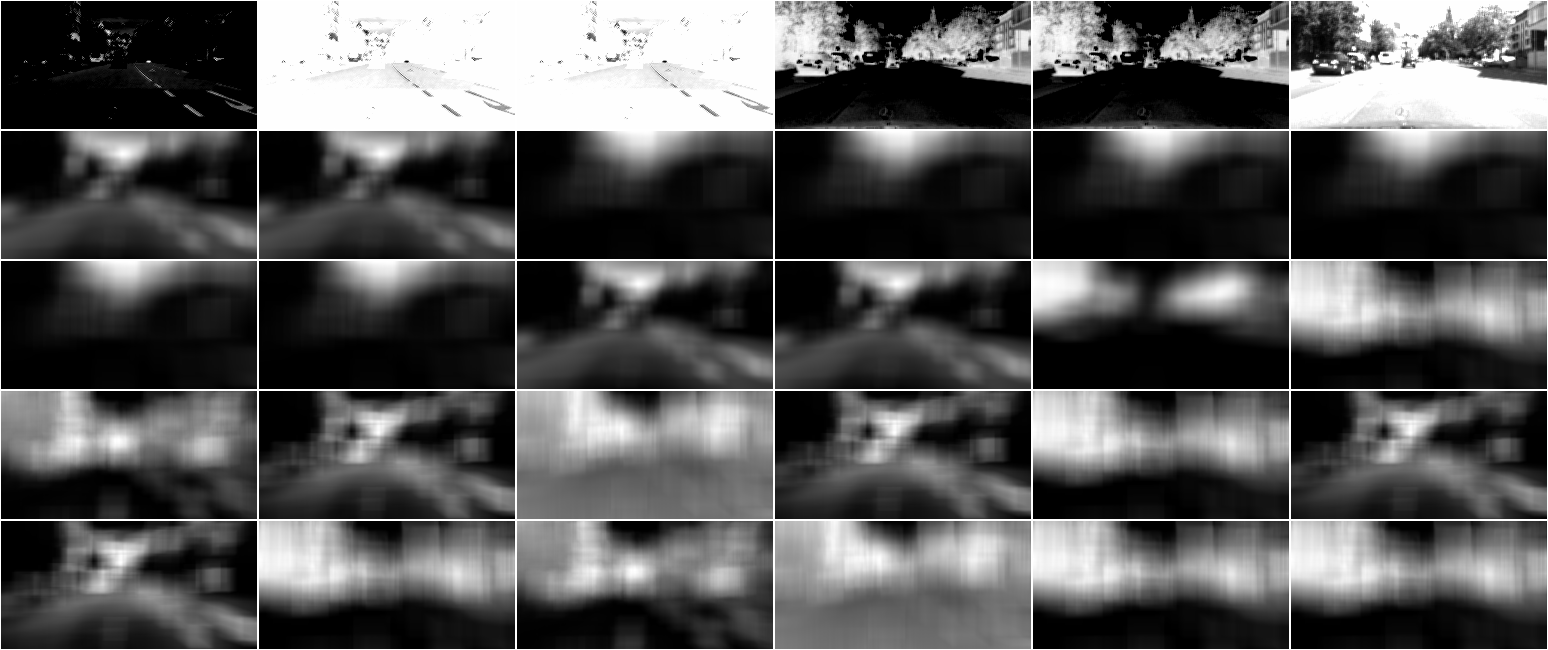

In [13]:
local imgs = {}
local outputFloat = net:get(5).output[1]:float()
local imgIdx = {368, 370, 365, 36, 40, 41, 18, 21, 130, 129, 131, 133, 128, 127, 17, 15, 287, 81, 374, 217, 77, 216, 83, 214, 213, 78, 378, 72, 84, 82}
print(imgIdx[17], imgIdx[18])
for _,idx in ipairs(imgIdx) do
    table.insert(imgs, outputFloat[idx])
    outputFloat[idx]:add(-outputFloat[idx]:min())
    outputFloat[idx]:div(outputFloat[idx]:max())
end

itorch.image(imgs)

In [17]:
local img, labels = cityscapes.loadSample(trainFiles[20])
print(img:size())
net:evaluate()
local imCuda = nn.utils.addSingletonDimension(img:cuda())
net:forward(imCuda)

    3
  512
 1024
[torch.LongStorage of size 3]



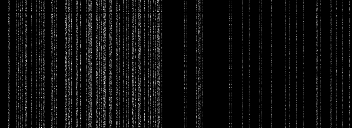

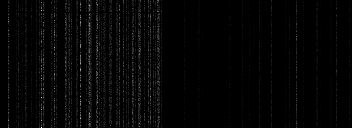

Conv output weight range:	-0.018104797229171	0.023803863674402	
Int output weight range:	-0.0087327193468809	0.0098521281033754	


137, 177, 112, 2, 100, 158, 130, 83, 190, 157, 25, 90, 144, 70, 126, 172, 39, 40, 102, 43, 161, 171, 183, 72, 27, 41, 176, 42, 159, 192, 

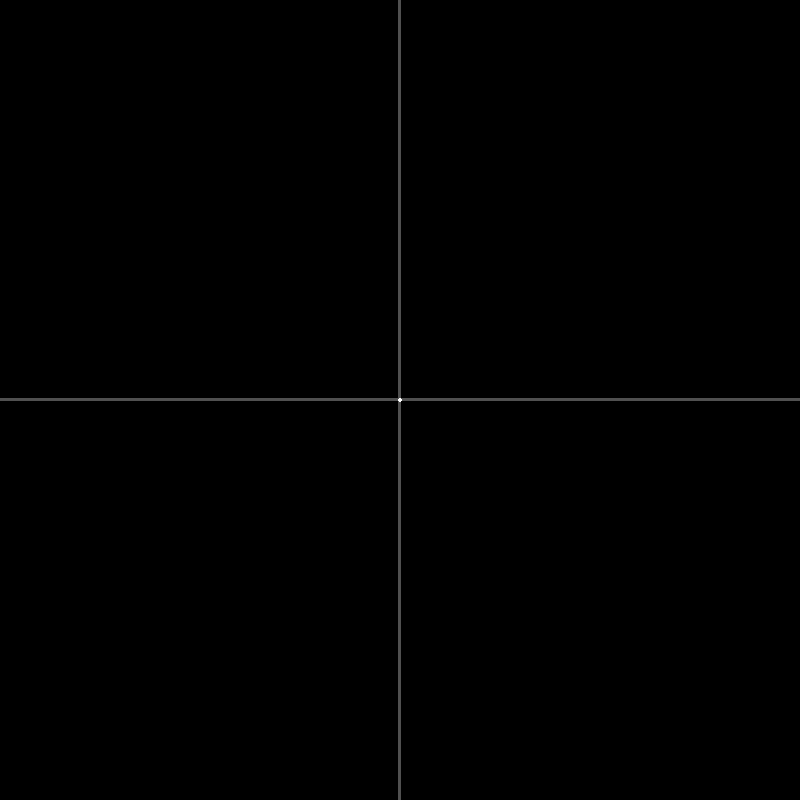

In [13]:
package.loaded.WindowDebugger = nil
require 'WindowDebugger'

local int = net:get(3):get(1):get(3):get(4)
local bn = net:get(3):get(2)
local conv = net:get(3):get(4)

local w = conv.weight:squeeze():float()
local bnW = bn.weight:float():view(1,-1)
local bnOutMeans = bn.output:float():abs():mean(3):mean(4):mean(1):view(1,-1)
itorch.image(torch.abs(w))
w:cmul(bnOutMeans:expandAs(w))
itorch.image(torch.abs(w))
wConv = w[{{}, {1, 64+96}}]
print('Conv output weight range:', wConv:min(), wConv:max())
w = w[{{}, {64+96+1, -1}}]
print('Int output weight range:', w:min(), w:max())
local scores = w:abs():mean(1):squeeze()
local worstIdx = select(2, torch.sort(scores, true))[{{1,30}}]
for k = 1,worstIdx:nElement() do io.stdout:write(worstIdx[k] .. ', ') end
itorch.image(WindowDebugger.drawBoxes(int, scores))

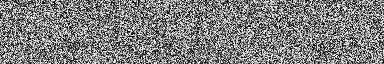

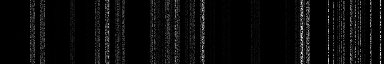

Conv output weight range:	-0.0054108942858875	0.0058372113853693	
Int output weight range:	-0.0055610118433833	0.0057473224587739	
302, 303, 203, 204, 109, 309, 176, 106, 308, 31, 307, 301, 153, 35, 45, 178, 155, 108, 41, 124, 310, 168, 169, 96, 107, 34, 118, 100, 201, 99, 

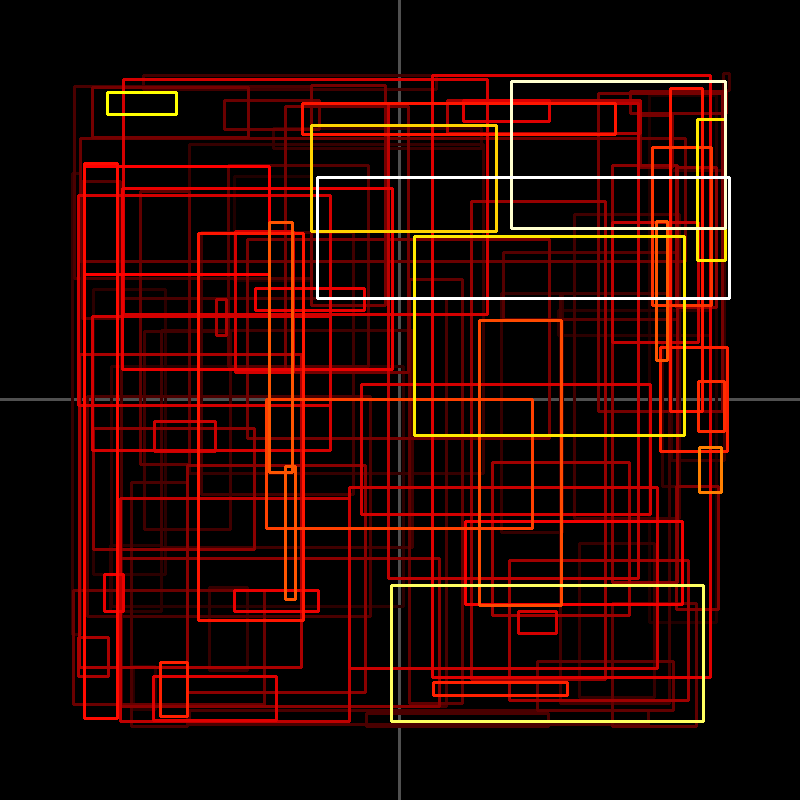

In [31]:
package.loaded.WindowDebugger = nil
require 'WindowDebugger'

local convIdx, bnIdx, concatIdx = 8,6,5
local int = net:get(concatIdx):get(1):get(2)
local bn = net:get(bnIdx)
local conv = net:get(convIdx)

local w = conv.weight:squeeze():float()
local bnW = bn.weight:float():view(1,-1)
local bnOutMeans = bn.output:float():abs():mean(3):mean(4):mean(1):view(1,-1)
itorch.image(torch.abs(w))
w:cmul(bnOutMeans:expandAs(w))
itorch.image(torch.abs(w))
wConv = w[{{}, {int.xMin:nElement()+1, -1}}]
print('Conv output weight range:', wConv:min(), wConv:max())
w = w[{{}, {1, int.xMin:nElement()}}]
print('Int output weight range:', w:min(), w:max())
local scores = w:abs():mean(1):squeeze()
local worstIdx = select(2, torch.sort(scores, true))[{{1,30}}]
for k = 1,worstIdx:nElement() do io.stdout:write(worstIdx[k] .. ', ') end
itorch.image(WindowDebugger.drawBoxes(int, scores))

In [25]:
local optimStatesList = separateParams and optimStates or {optimStates}
for k = 1,#optimStatesList do
    optimStatesList[k].learningRate = optimStatesList[k].learningRate / 2
    optimStatesList[k].t = 0
    optimStatesList[k].m:zero()
    optimStatesList[k].v:zero()
end

In [30]:
-- do this after INTERRUPTing
net:clearState()
torch.save(outputDir .. 'net.t7', {net, optimStates, GSconfig})

torch.save(outputDir .. 'evalLogger.t7', evalLogger.symbols)
torch.save(outputDir .. 'evalAccLogger.t7', evalAccLogger.symbols)
torch.save(outputDir .. 'onlineLossLogger.t7', onlineLossLogger.symbols)

if wDebs then
    for k = 1,#wDebs do
        wDebs[k]:exportVideo(outputDir .. 'int-layer-' .. k .. '.avi')
    end
end

## Export images for evaluation by `cityscapesScripts`

In [1]:
net:evaluate()
print(net.train)

valLoss, valIOUclass, valIOUcategory = evaluate(net, valFiles, evaluationIdxVal)
print(valIOUclass, valIOUcategory)

net:training()

false	


0.52681039523725	0.79629463808877	


In [34]:
net:evaluate()

function getResultFilename(s)
    local slashIdx = s:find('/')
    s = s:sub(slashIdx+1, -1)
    local slashIdx = s:find('/')
    s = s:sub(slashIdx+1, -1)
    local slashIdx = s:find('/')
    return s:sub(slashIdx+1, -16) .. 'result.png'
end

print('Total ' .. #valFiles)

os.execute('mkdir "' .. cityscapes.relative .. 'results" -p')
local input = torch.CudaTensor()

for k = 1,#valFiles do
    if k % 50 == 0 then print(k) end
    
    local img, labels = cityscapes.loadSample(valFiles[k])

    input:resize(img:size())
    input:copy(img)
    local outputs = net:forward(nn.utils.addSingletonDimension(input))[1]
    local outLabels = 
        select(2, outputs:float():view(cityscapes.dsize[2], cityscapes.dsize[1], nClasses)
            :max(3)):squeeze()
    local outLabelsEval = cityscapes.labelsToEval(outLabels)
    
--     itorch.image(outLabelsEval)
    image.savePNG(
        cityscapes.relative .. 'results/' .. getResultFilename(valFiles[k].image), 
        image.scale(outLabelsEval, 2048, 1024, 'simple'))
end

net:training()

Total 500	


50	


100	


150	


200	


250	


300	


350	


400	


450	


500	
